In [3]:
%load_ext autoreload
%autoreload 2
import sys
if ".." not in sys.path:
    sys.path.append("..")

import numpy as np
from scipy.integrate import cumulative_trapezoid
from scipy.special import gamma
import matplotlib
import matplotlib.pyplot as plt

from volterra_hawkes.kernel.exponential_kernel import ExponentialKernel
from volterra_hawkes.kernel.constant_kernel import ConstantKernel
from volterra_hawkes.kernel.fractional_kernel import FractionalKernel

my_green = "#5b6c64"
my_copper = "#B56246"
plt.rcParams["figure.figsize"]        = ((1 + np.sqrt(5)) / 2 * 5, 5)
plt.rcParams["figure.autolayout"]     = True
plt.rcParams["patch.force_edgecolor"] = False
plt.rcParams["axes.grid"]             = True
plt.rcParams['axes.prop_cycle']       = matplotlib.cycler(color=[my_green, my_copper, "#322B4D", "#28BC9C", "#71074E"]) 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Constant kernel $K(t) = c$

In [4]:
c = 3

K = ConstantKernel(c=c)

explicit_kernel = lambda t: c * np.ones_like(t)

t_grid = np.linspace(0, 10, 5000)

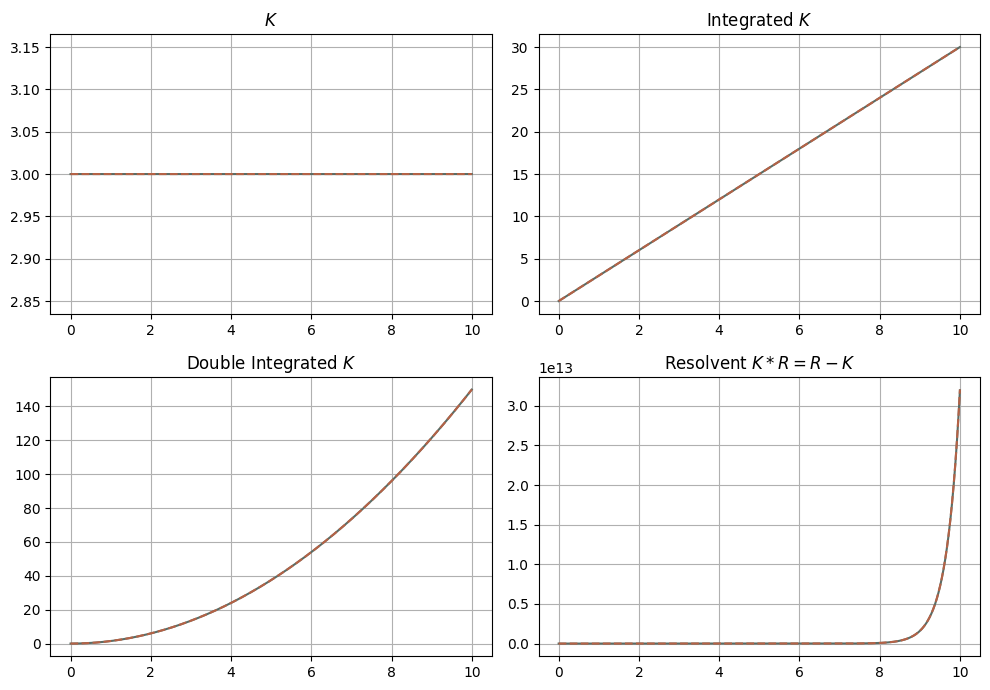

In [5]:
fig, ax = plt.subplots(2, 2, figsize=(10, 7))

K_grid = K.kernel(t_grid)
ax[0, 0].plot(t_grid, K_grid)
ax[0, 0].plot(t_grid, explicit_kernel(t_grid), "--")
ax[0, 0].set_title("$K$")

K_bar_grid = K.integrated_kernel(t_grid)

ax[0, 1].plot(t_grid, K_bar_grid)
ax[0, 1].plot(t_grid, cumulative_trapezoid(K_grid, t_grid, initial=0), "--")
ax[0, 1].set_title("Integrated $K$")

ax[1, 0].plot(t_grid, K.double_integrated_kernel(t_grid))
ax[1, 0].plot(t_grid, cumulative_trapezoid(K_bar_grid, t_grid, initial=0), "--")
ax[1, 0].set_title("Double Integrated $K$")

R_grid = K.resolvent(t_grid)
K_mat = np.tril(K.kernel(t_grid[:, None] - t_grid[None, :]), k=-1)
dt = t_grid[1] - t_grid[0]

ax[1, 1].plot(t_grid, K_mat @ R_grid * dt)
ax[1, 1].plot(t_grid, R_grid - K_grid, "--")
ax[1, 1].set_title("Resolvent $K * R = R - K$")

plt.show()

## Exponential Kernel $K(t) = c e^{-\lambda t}$

In [6]:
c, lam = 2, 3

K = ExponentialKernel(c=c, lam=lam)

explicit_kernel = lambda t: c * np.exp(-lam * t)

t_grid = np.linspace(0, 10, 5000)

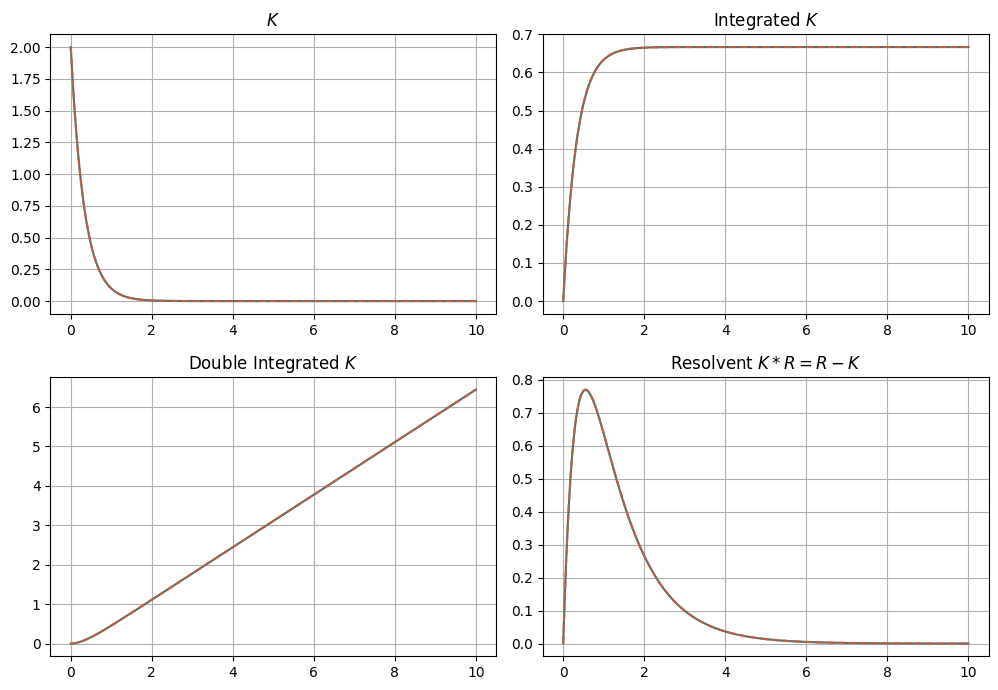

In [7]:
fig, ax = plt.subplots(2, 2, figsize=(10, 7))

K_grid = K.kernel(t_grid)
ax[0, 0].plot(t_grid, K_grid)
ax[0, 0].plot(t_grid, explicit_kernel(t_grid), "--")
ax[0, 0].set_title("$K$")

K_bar_grid = K.integrated_kernel(t_grid)

ax[0, 1].plot(t_grid, K_bar_grid)
ax[0, 1].plot(t_grid, cumulative_trapezoid(K_grid, t_grid, initial=0), "--")
ax[0, 1].set_title("Integrated $K$")

ax[1, 0].plot(t_grid, K.double_integrated_kernel(t_grid))
ax[1, 0].plot(t_grid, cumulative_trapezoid(K_bar_grid, t_grid, initial=0), "--")
ax[1, 0].set_title("Double Integrated $K$")

R_grid = K.resolvent(t_grid)
K_mat = np.tril(K.kernel(t_grid[:, None] - t_grid[None, :]), k=-1)
dt = t_grid[1] - t_grid[0]

ax[1, 1].plot(t_grid, K_mat @ R_grid * dt)
ax[1, 1].plot(t_grid, R_grid - K_grid, "--")
ax[1, 1].set_title("Resolvent $K * R = R - K$")

plt.show()

## Fractional Kernel $K(t) = c \frac{t^{H-0.5}}{\Gamma(H+0.5)}$

In [8]:
c, H = 0.5, 0.3

K = FractionalKernel(c=c, H=H)

explicit_kernel = lambda t: c * t**(H - 0.5) / gamma(H + 0.5)

t_grid = np.linspace(0.0001, 3, 10000)

C:\Users\DM6579\OneDrive - ENGIE\projects\volterra_hawkes\notebooks\..\volterra_hawkes\kernel\fractional_kernel.py:18: RuntimeWarning: divide by zero encountered in power
  return self.c * t**(alpha - 1) / gamma(alpha)
C:\Users\DM6579\OneDrive - ENGIE\projects\volterra_hawkes\notebooks\..\volterra_hawkes\kernel\fractional_kernel.py:18: RuntimeWarning: invalid value encountered in power
  return self.c * t**(alpha - 1) / gamma(alpha)


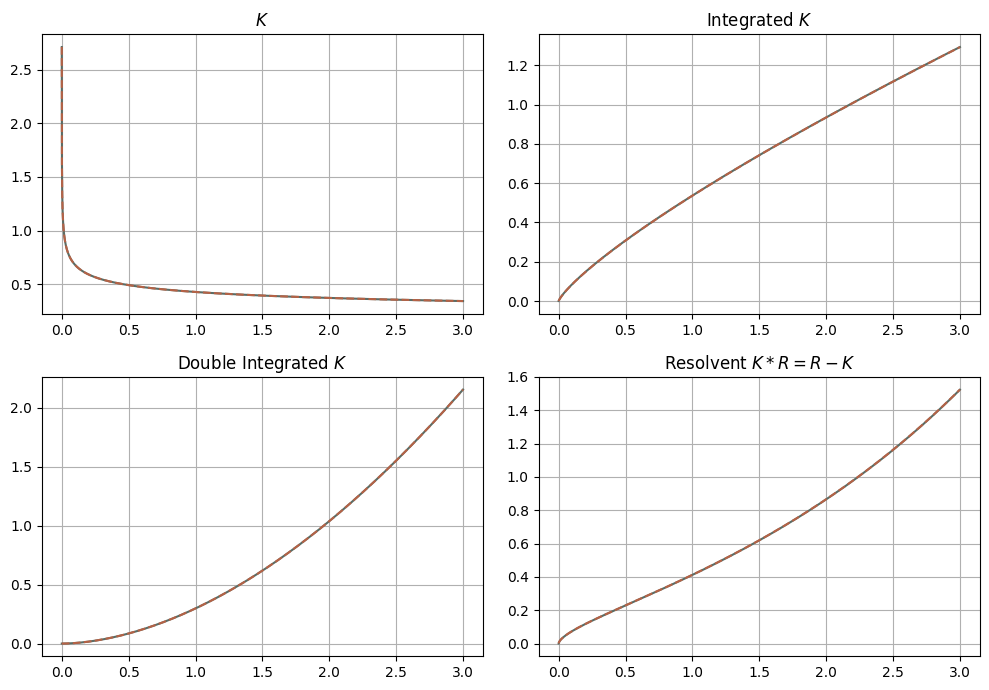

In [9]:
fig, ax = plt.subplots(2, 2, figsize=(10, 7))

K_grid = K.kernel(t_grid)
ax[0, 0].plot(t_grid, K_grid)
ax[0, 0].plot(t_grid, explicit_kernel(t_grid), "--")
ax[0, 0].set_title("$K$")

K_bar_grid = K.integrated_kernel(t_grid)

ax[0, 1].plot(t_grid, K_bar_grid)
ax[0, 1].plot(t_grid, cumulative_trapezoid(K_grid, t_grid, initial=0), "--")
ax[0, 1].set_title("Integrated $K$")

ax[1, 0].plot(t_grid, K.double_integrated_kernel(t_grid))
ax[1, 0].plot(t_grid, cumulative_trapezoid(K_bar_grid, t_grid, initial=0), "--")
ax[1, 0].set_title("Double Integrated $K$")

R_grid = K.resolvent(t_grid)
K_mat = np.tril(K.kernel(t_grid[:, None] - t_grid[None, :]), k=-1)
dt = t_grid[1] - t_grid[0]

ax[1, 1].plot(t_grid, K_mat @ R_grid * dt)
ax[1, 1].plot(t_grid, R_grid - K_grid, "--")
ax[1, 1].set_title("Resolvent $K * R = R - K$")

plt.show()